In [1]:
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.environments import py_environment


class StockAttackEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(5,), dtype=np.float64, minimum=0, name='observation')
    self._episode_ended        = False
    self.episodeTimeStepNumber = 0
    self.capital               = np.random.randint(0,2)
    self.ownedStock            = np.random.randint(0,2)
    self.lengthData            = 5
    self.data                  = np.ones(self.lengthData) * self.ownedStock  #data is random either all 1 or all 0
    self.changePosition        = np.random.randint(0, self.lengthData)
    #import pdb; pdb.set_trace()
    self.data[self.changePosition: self.lengthData] = np.ones(self.lengthData - self.changePosition) * np.random.randint(0,2) # data can either have a positive or negative jump, or no change at all
    self.cost                  = 0
    self.portfolioValue        = self.capital + self.ownedStock * self.data[0]
    self.initialPortfolioValue = self.capital + self.ownedStock * self.data[0]

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self.capital               = np.random.randint(0,2)
    self.ownedStock            = np.random.randint(0,2)
    self.data                  = np.ones(self.lengthData) * self.ownedStock  #data is random either all 1 or all 0
    self.changePosition        = np.random.randint(0, self.lengthData)
    self.data[self.changePosition: self.lengthData] = np.ones(self.lengthData - self.changePosition) * np.random.randint(0,2) # data can either have a positive or negative jump, or no change at all
    self.cost                  = 0
    self.portfolioValue        = self.capital + self.ownedStock * self.data[0]
    self._episode_ended        = False
    self.episodeTimeStepNumber = 0
    self._observation_spec     = [self.data[self.episodeTimeStepNumber], self.data[self.episodeTimeStepNumber], 0, self.capital, self.ownedStock]
    self.initialPortfolioValue = self.capital + self.ownedStock * self.data[0]
    return ts.restart(np.array(self._observation_spec))

  def _step(self, action):
    if self._episode_ended:
      return self.reset()

    price_buy  = self.data[self.episodeTimeStepNumber]+self.cost
    price_sell = self.data[self.episodeTimeStepNumber]-self.cost
    plausible  = True

    
    if action == 1:
        plausible = (self.ownedStock == 0) and (self.capital >= price_buy)
        if plausible:
            self.capital    -= price_buy
            self.ownedStock  = 1
    elif action == 0:
        pass
    elif action == 2:
        plausible = (self.ownedStock == 1)
        if plausible:
            self.capital   += price_sell * self.ownedStock
            self.ownedStock = 0
    else:
      raise ValueError('`action` should be 0 or 1.')

    
    self.portfolioValue = self.capital + self.ownedStock * price_sell
    plausbilityPenalty  = 0
    if not plausible:
        plausbilityPenalty = 1
    reward = self.portfolioValue - plausbilityPenalty - self.initialPortfolioValue


    self._action_spec = [action]
    if self.episodeTimeStepNumber >= 1:
        self._observation_spec = [self.data[self.episodeTimeStepNumber-1], self.data[self.episodeTimeStepNumber], plausbilityPenalty, self.capital, self.ownedStock]
    else:
        self._observation_spec = [self.data[self.episodeTimeStepNumber], self.data[self.episodeTimeStepNumber], plausbilityPenalty, self.capital, self.ownedStock]

        
    if self.data.shape[0]-1>self.episodeTimeStepNumber:
        self.episodeTimeStepNumber +=1
        #import pdb; pdb.set_trace()
        return ts.transition(np.array(self._observation_spec), reward, discount=0.0)
    else:
      self._episode_ended = True
      return ts.termination(np.array(self._observation_spec), reward)

In [2]:
environment = StockAttackEnv()
action = np.array([2])
time_step = environment.reset()
stocks = []
while not time_step.is_last():
  time_step = environment.step(action)
  stocks.append(environment.ownedStock)
#  print(time_step)
    
import matplotlib.pyplot as plt
#plt.plot(environment.data)
#plt.plot(stocks)

In [3]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]
    

def collect_episode(environment, policy, replay_buffer, num_episodes):

  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

    if traj.is_boundary():
      episode_counter += 1

In [4]:
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

## setup agent
learning_rate = 1e-3
numerNeurons = 100

tf.compat.v1.enable_v2_behavior()

env = tf_py_environment.TFPyEnvironment(StockAttackEnv())
env.reset()

fc_layer_params = (numerNeurons,)

q_net = q_network.QNetwork(
    env.observation_spec(),
    env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

W1108 10:17:44.713101  9928 base_layer.py:2081] Layer QNetwork is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W1108 10:17:44.736102  9928 base_layer.py:2081] Layer TargetQNetwork is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If 

In [5]:
## replay buffer
replay_buffer_max_length = 1000
batch_size = 64

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=replay_buffer_max_length)

In [6]:
## simple training agent
num_eval_episodes = 10
num_iterations = 10000
collect_steps_per_iteration = 2
log_interval  = 200
eval_interval = 200

agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)

avg_return = compute_avg_return(env, agent.policy, num_eval_episodes)
returns = [avg_return]
print(returns)

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_episode(env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)
  iterator = iter(dataset)
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

[-1.9]
step = 200: loss = 0.019072478637099266
step = 200: Average Return = -0.6000000238418579
step = 400: loss = 0.005572913214564323
step = 400: Average Return = -0.30000001192092896
step = 600: loss = 0.026451455429196358
step = 600: Average Return = 0.0
step = 800: loss = 0.0502922460436821
step = 800: Average Return = 0.4000000059604645
step = 1000: loss = 0.022215500473976135
step = 1000: Average Return = 0.0
step = 1200: loss = 0.0022562388330698013
step = 1200: Average Return = 0.0
step = 1400: loss = 0.03270304948091507
step = 1400: Average Return = -0.30000001192092896
step = 1600: loss = 0.06809110939502716
step = 1600: Average Return = 0.0
step = 1800: loss = 0.028497599065303802
step = 1800: Average Return = 0.20000000298023224
step = 2000: loss = 0.04189049080014229
step = 2000: Average Return = -0.20000000298023224
step = 2200: loss = 0.05686415359377861
step = 2200: Average Return = 0.0
step = 2400: loss = 0.013332396745681763
step = 2400: Average Return = -0.100000001

-1.0

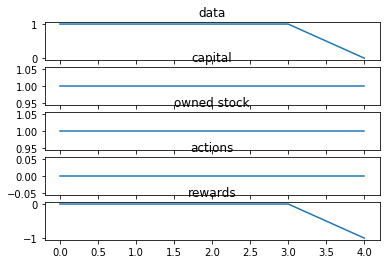

In [10]:
def evaluate_policy(environment, policy):
  total_return = 0.0
  time_step = environment.reset()

  data = []
  rewards = []
  actions = []
  ownedStocks = []
  ownedCapital = []
  while not time_step.is_last():
    action_step = policy.action(time_step)
    time_step   = environment.step(action_step.action)
    total_return += time_step.reward
    actions.append(action_step.action)
    rewards.append(time_step.reward)
    data.append(time_step.observation.numpy()[0][1])
    ownedStocks.append(time_step.observation.numpy()[0][4])
    ownedCapital.append(time_step.observation.numpy()[0][3])

  ax1 = plt.subplot(5,1,1)
  ax1.plot(data)
  ax1.set_title('data')
  ax2 = plt.subplot(5,1,2)
  ax2.plot(ownedCapital)
  ax2.set_title('capital')
  ax3 = plt.subplot(5,1,3)
  ax3.plot(ownedStocks)
  ax3.set_title('owned stock')
  ax4 = plt.subplot(5,1,4)
  ax4.plot(actions)
  ax4.set_title('actions')
  ax5 = plt.subplot(5,1,5)
  ax5.plot(rewards)
  ax5.set_title('rewards')
  return total_return.numpy()[0]

plt.plot(returns)
evaluate_policy(env, agent.policy)